# Exploring overfitting

### Imports

In [1]:
import numpy as np

from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
sns.set_style("whitegrid")

from sklearn.linear_model import LogisticRegression

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

Using TensorFlow backend.


### Settings

In [13]:
# number of samples in the data set
N_SAMPLES = 2000
# ratio between training and test sets
TEST_SIZE = 0.2
# boundary of the graph
GRID_PADDING = 0.5
GRID_STEP = 0.01
# number of iterations of the neural network
N_EPOCHS = 200

### Create artificial dataset

In [94]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.4, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=42)

### Definition of grid

In [95]:
x_min, x_max = X[:, 0].min() - GRID_PADDING, X[:, 0].max() + GRID_PADDING
y_min, y_max = X[:, 1].min() - GRID_PADDING, X[:, 1].max() + GRID_PADDING
XX, YY = np.meshgrid(np.arange(x_min, x_max, GRID_STEP), np.arange(y_min, y_max, GRID_STEP))

### Auxiliary plotting function

In [96]:
def make_plot(X, y, XX, YY, preds, plot_name, file_name):
    plt.figure(figsize=(10,10))
    axes = plt.gca()
    axes.set_xlim([x_min,x_max])
    axes.set_ylim([y_min,y_max])
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=20)
    plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 0.6, cmap=cm.Spectral)
    plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    plt.savefig(file_name)
    # plt.close()

### Visualization of the data set

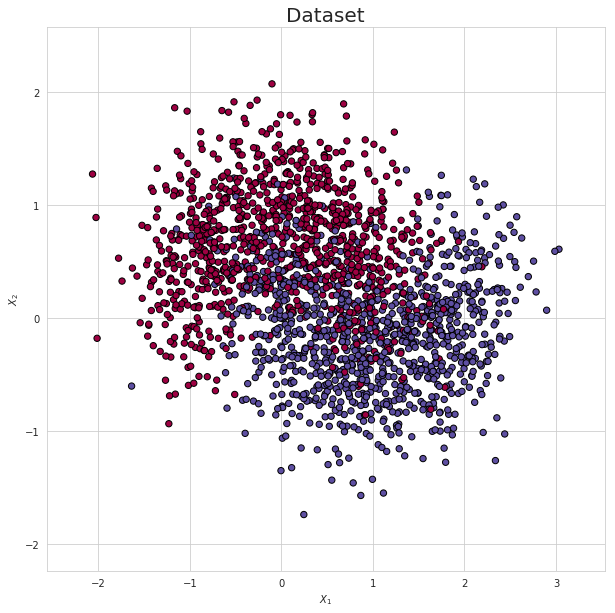

In [97]:
plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
axes.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title("Dataset", fontsize=20)
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black');
plt.savefig("dataset.png")

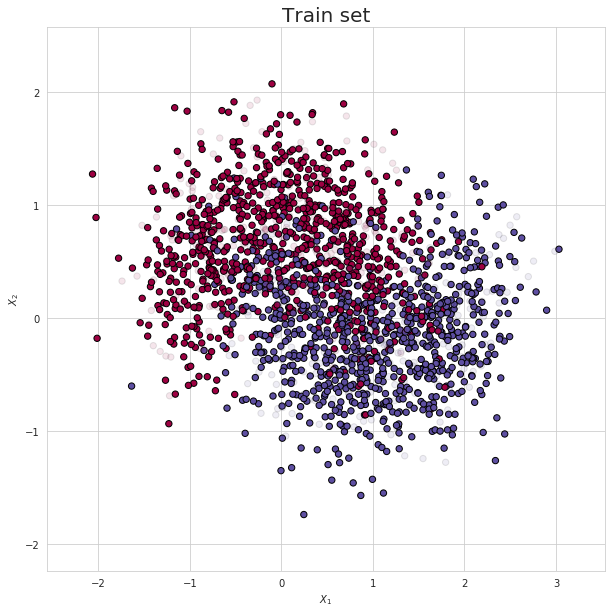

In [98]:
plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
axes.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title("Train set", fontsize=20)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black');
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black', alpha=0.1);
plt.savefig("train_set.png")

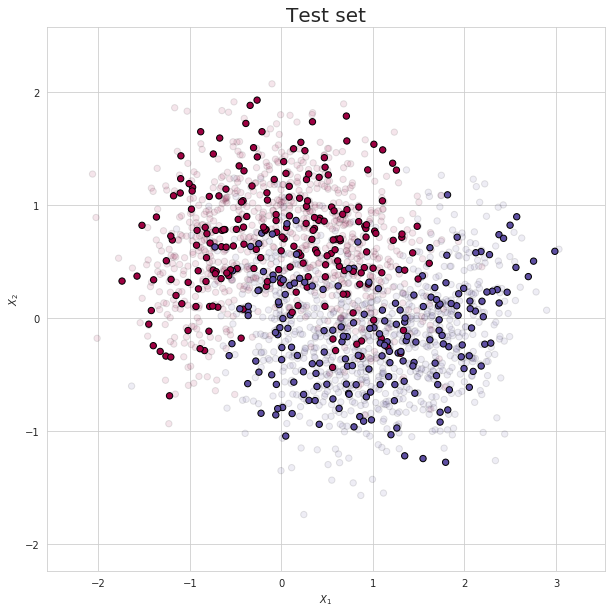

In [99]:
plt.figure(figsize=(10,10))
axes = plt.gca()
axes.set_xlim([x_min,x_max])
axes.set_ylim([y_min,y_max])
axes.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title("Test set", fontsize=20)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black', alpha=0.1);
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black');
plt.savefig("test_set.png")

### Logistic regression (high bias)

In [100]:
regressor = LogisticRegression()
regressor.fit(X_train, y_train)
y_train_pred_1 = regressor.predict(X_train)
y_test_pred_1 = regressor.predict(X_test)
train_acc = accuracy_score(y_train, y_train_pred_1)
test_acc = accuracy_score(y_test, y_test_pred_1)
print("Train accuracy: " + str(train_acc))
print("Test accuracy: " + str(test_acc))

Train accuracy: 0.829375
Test accuracy: 0.85


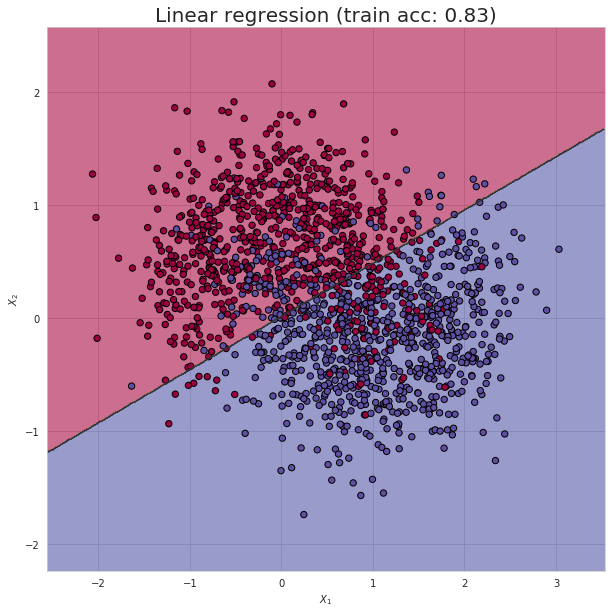

In [101]:
preds = regressor.predict(np.c_[XX.ravel(), YY.ravel()])
title = "Linear regression (train acc: {0:.2f})".format(train_acc)
file = "linear_regression_train.png"
make_plot(X_train, y_train, XX, YY, preds, title, file)

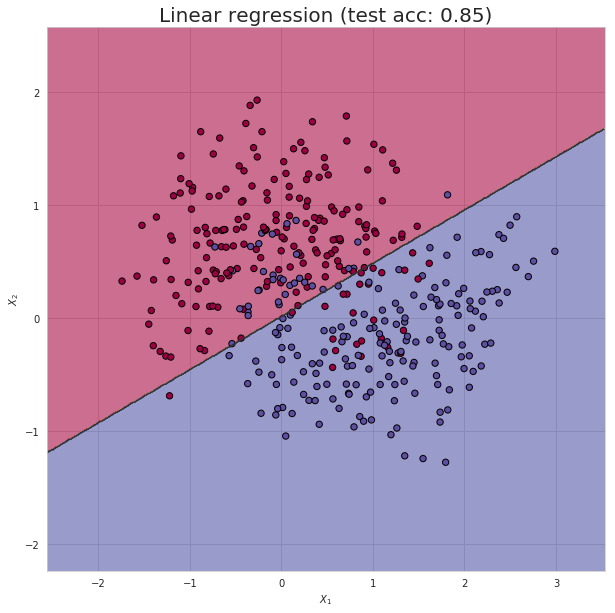

In [102]:
preds = regressor.predict(np.c_[XX.ravel(), YY.ravel()])
title = "Linear regression (test acc: {0:.2f})".format(test_acc)
file = "linear_regression_test.png"
make_plot(X_test, y_test, XX, YY, preds, title, file)

### Neural network without regularisation (high variance)

In [103]:
model = Sequential()
model.add(Dense(8, input_dim=2,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)

In [104]:
y_train_pred_2 = model.predict_classes(X_train)
y_test_pred_2 = model.predict_classes(X_test)
train_acc = accuracy_score(y_train, y_train_pred_2)
test_acc = accuracy_score(y_test, y_test_pred_2)
print("Train accuracy: " + str(train_acc))
print("Test accuracy: " + str(test_acc))

Train accuracy: 0.889375
Test accuracy: 0.84


In [105]:
model_json = model.to_json()
with open("nn_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("nn_model.h5")
print("Saved model to disk")

Saved model to disk


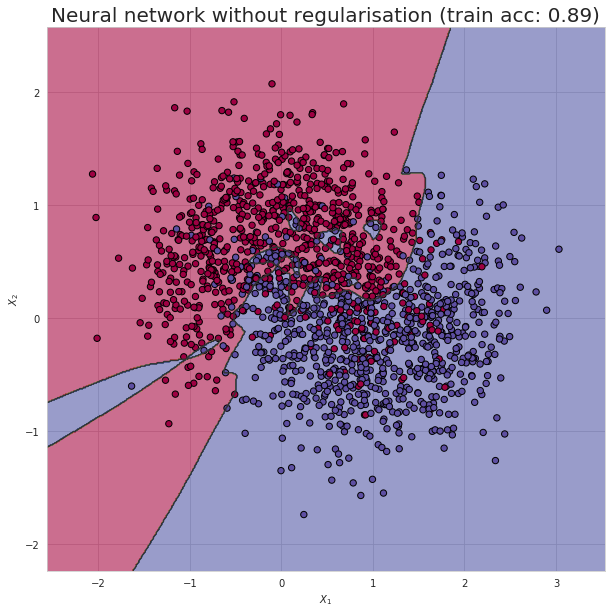

In [106]:
preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
title = "Neural network without regularisation (train acc: {0:.2f})".format(train_acc)
file = "nn_train.png"
make_plot(X_train, y_train, XX, YY, preds, title, file)

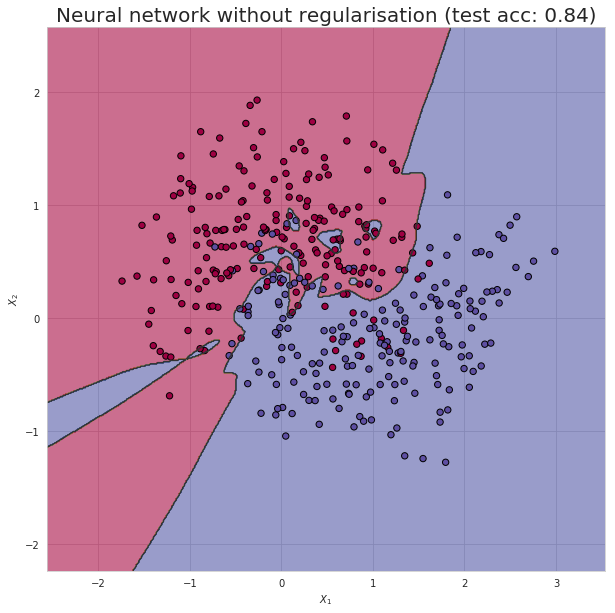

In [107]:
preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
title = "Neural network without regularisation (test acc: {0:.2f})".format(test_acc)
file = "nn_test.png"
make_plot(X_test, y_test, XX, YY, preds, title, file)

### Neural network with regularisation (just right)

In [108]:
model = Sequential()
model.add(Dense(8, input_dim=2,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=N_EPOCHS, verbose=0)

In [109]:
y_train_pred_3 = model.predict_classes(X_train)
y_test_pred_3 = model.predict_classes(X_test)
train_acc = accuracy_score(y_train, y_train_pred_3)
test_acc = accuracy_score(y_test, y_test_pred_3)
print("Train accuracy: " + str(train_acc))
print("Test accuracy: " + str(test_acc))

Train accuracy: 0.86875
Test accuracy: 0.8775


In [110]:
model_json = model.to_json()
with open("nn_reg_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("nn_reg_model.h5")
print("Saved model to disk")

Saved model to disk


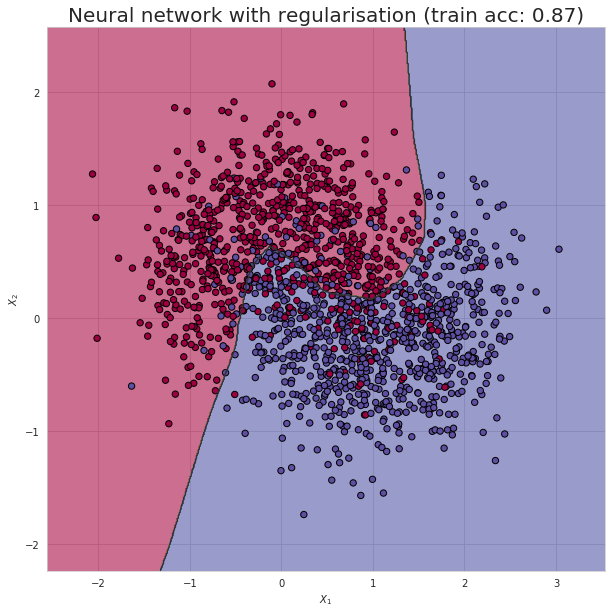

In [111]:
preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
title = "Neural network with regularisation (train acc: {0:.2f})".format(train_acc)
file = "nn_reg_train.png"
make_plot(X_train, y_train, XX, YY, preds, title, file)

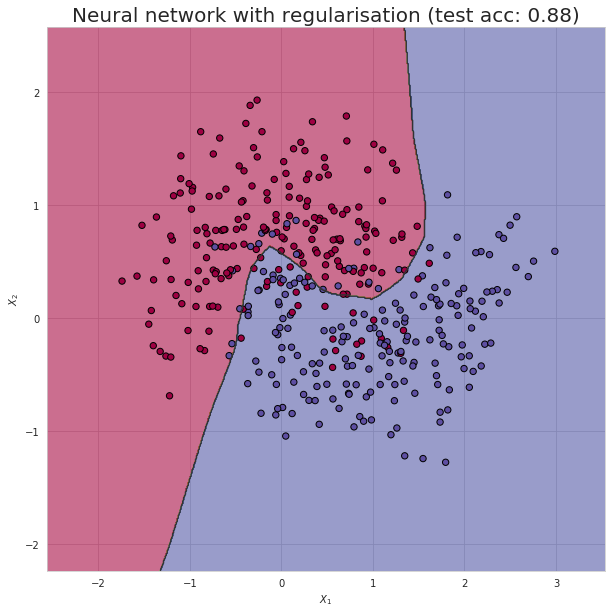

In [112]:
preds = model.predict_classes(np.c_[XX.ravel(), YY.ravel()])
title = "Neural network with regularisation (test acc: {0:.2f})".format(test_acc)
file = "nn_reg_test.png"
make_plot(X_test, y_test, XX, YY, preds, title, file)